## Library Imports

In [39]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd  
import datetime  # Datetime module for handling dates and times
from binance.client import Client 
from sklearn.preprocessing import StandardScaler  # StandardScaler for feature scaling
from keras.layers import Bidirectional  # Bidirectional layer for bidirectional LSTM
from keras.regularizers import l2  # l2 regulariser for regularisation
from keras.optimizers import Adam  # Adam optimiser for training
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score  
from keras.models import Sequential  # Sequential model for building neural networks
from keras.layers import Dense, Activation, Dropout, LSTM  # Layers for neural networks
from datetime import datetime  
import seaborn as sns  

## Binance API Setup

In [ ]:
# Define Binance API keys
api_key = "zvbkdnp5VMDAdtX4WMNtmxQC4wbVukTcTpX3PRrs1UYIz9T2zW5j5uNAJagdCq04"    # Binance API key
secret_key = "KcoIju1CD9ULVV5e2KlIgfPsQNGkYcEM1r0DMcv5bic9EC8e7zURdeeR5UOUJ5ZZ"  # Binance API secret key

# Initialise Binance client
client = Client(api_key, secret_key)

# Fetch candlestick data from Binance
symbol = 'BTCUSDT'  # Symbol for BTC against USDT
interval = Client.KLINE_INTERVAL_15MINUTE  # Interval for candlestick data
limit = 1000  # Number of data points to fetch
dataset = client.get_klines(symbol=symbol, interval=interval, limit=limit)  # Fetch candlestick data

These lines of code set the correct setting to retrieve Bitcoin candlestick data against USDT via the Binance API. It imports critical libraries for data manipulation, analysis, visualisation and machine learning model development, sets up the Binance client with API credentials and retrieves the necessary data.

## Data Processing

In [40]:
# Extract closing prices and timestamps from candlestick data
closing_prices = np.array([float(data[4]) for data in dataset])  # closing prices for 1000 candles
timestamps = np.array([int(data[0]) for data in dataset])  # Timestamps for 1000 candles
time_strings = np.array([datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S') for timestamp in timestamps])  # Convert timestamps to readable form for 1000 candles

# Create a DataFrame for the candlestick chart
df = pd.DataFrame({'Date': time_strings, 'Close': closing_prices})  # Create df with timestamps and closing prices
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as index

The closing prices and timestamps are collected from the Binance API's candlestick dataset. The timestamps are then turned into date-time strings that humans can understand. The extracted data is then stored in a pandas DataFrame, which includes columns for the date and closing price. After that, the date column is transformed to datetime format and used as the DataFrame's index.

## Visualisation

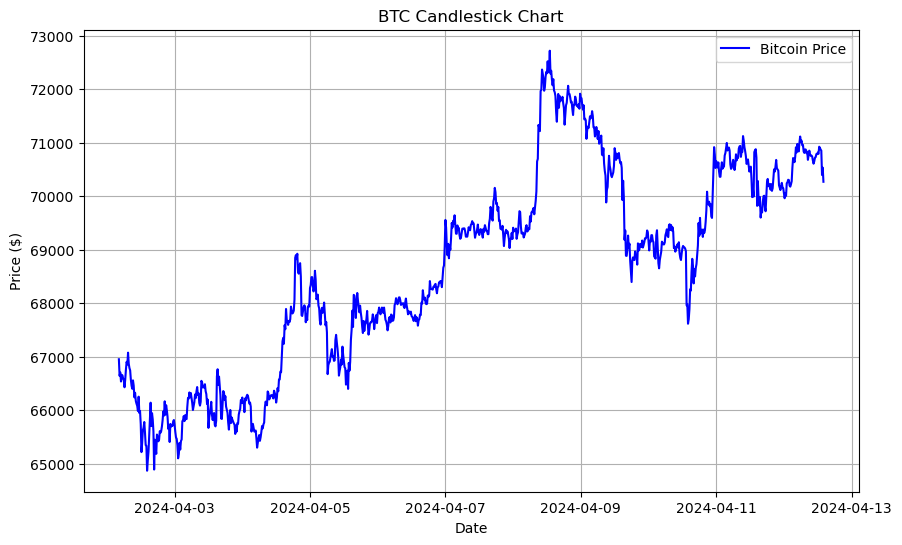

In [13]:
# Plotting the chart
plt.figure(figsize=(10, 6))  
plt.plot(df.index, df['Close'], label='Bitcoin Price', color='blue')  # Closing prices
plt.title('BTC Candlestick Chart')  
plt.xlabel('Date')  
plt.ylabel('Price ($)')  
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [14]:
# Creating a DF for minute-by-minute price data
price_data = pd.DataFrame({'Time': time_strings, 'Price_BTC': closing_prices})

## Data Preprocessing

In [41]:
# Reshape the price array to a column vector
price = closing_prices.reshape(-1, 1) 

scaler = StandardScaler()  # StandardScaler object for standardising the price 

# Fit the scaler on the first 800 candles for training
scaler.fit(price[:800])  

price_standardised = scaler.transform(price)  # Standardising the price using the fitted scaler

# Reshape the standardised price to have 200 rows and 5 columns
price_reshaped = price_standardised.reshape(200, 5)  

# DataFrame with input and target columns for model training
new_columns = ['Scaled_Price_1', 'Scaled_Price_2', 'Scaled_Price_3', 'Scaled_Price_4', 'Target_Price']
df = pd.DataFrame(price_reshaped, columns=new_columns)  

# Printing the DataFrame to visualise the data structure
print(df)  

     Scaled_Price_1  Scaled_Price_2  Scaled_Price_3  Scaled_Price_4  \
0         -1.445298       -1.497746       -1.573972       -1.531713   
1         -1.408004       -1.445860       -1.374971       -1.328456   
2         -1.394202       -1.497987       -1.526965       -1.486206   
3         -1.279187       -1.332809       -1.319007       -1.333880   
4         -1.371987       -1.403543       -1.509435       -1.462691   
..              ...             ...             ...             ...   
195       -0.902375       -0.918405       -0.888040       -0.792417   
196       -0.760059       -0.815514       -0.780969       -0.757912   
197       -0.747752       -0.711729       -0.796998       -0.872606   
198       -0.744310       -0.708408       -0.632067       -0.606863   
199       -0.687023       -0.626059       -0.606296       -0.716826   

     Target_Price  
0       -1.489849  
1       -1.412202  
2       -1.261800  
3       -1.298350  
4       -1.765568  
..            ...  
195    

The price data preparation for model training is the main objective of the code block above. The price array must be reshaped into a column vector, the data must be standardised using StandardScaler then the standardised price array must be reshaped into a structured DataFrame for further analysis. It also outputs the DataFrame so that the structure and scaled pricing data can be seen.

## Data Splitting


In [42]:
# Split train and test data
train_samples = 150  # Number of samples for training
test_samples = 50  # Number of samples for testing

# Features and target column for training data
x_train = df.iloc[:train_samples, :-1]
y_train = df.iloc[:train_samples, -1]

# Features and target column for testing data
x_test = df.iloc[train_samples:train_samples + test_samples, :-1]
y_test = df.iloc[train_samples:train_samples + test_samples, -1]

## Data Preparation for LSTM

In [43]:
# Reshape input data for LSTM model
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1)) 
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))  

In [44]:
# Printing the shape of train and test data
print("Shape of training data (x_train):", x_train.shape)
print("Shape of testing data (x_test):", x_test.shape)


Shape of training data (x_train): (150, 4, 1)
Shape of testing data (x_test): (50, 4, 1)


This code paragraph separates the dataset into training and test sets. It provides the amount of samples for each set, extracts the features and target columns, reshapes the input data to be LSTM compatible, then releases the shapes of the generated arrays for verification.

## Model Definition

In [45]:
# Set random seed for reproducibility
np.random.seed(42)
# Define the model architecture
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(0.001)),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Build the model
model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))

# Printing the model summary
print("Model Summary:")
model.summary()

Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 4, 256)           133120    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 256)            0         
                                                                 
 lstm_7 (LSTM)               (None, 4, 64)             82176     
                                                                 
 dropout_5 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                       

This block of code generates a random seed for reproducibility, defines the architecture of a sequential neural network model with LSTM layers and regularisation, compiles the model with the Adam optimizer and mean squared error loss function, builds the model based on the input shape and displays a summary of the model architecture.

## Model Training

In [46]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
5/5 [==============================] - 11s 862ms/step - loss: 1.2614 - val_loss: 1.1317
Epoch 2/100
5/5 [==============================] - 0s 33ms/step - loss: 1.1094 - val_loss: 0.9781
Epoch 3/100
5/5 [==============================] - 0s 29ms/step - loss: 0.9341 - val_loss: 0.7880
Epoch 4/100
5/5 [==============================] - 0s 30ms/step - loss: 0.7327 - val_loss: 0.5669
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: 0.5243 - val_loss: 0.3743
Epoch 6/100
5/5 [==============================] - 0s 28ms/step - loss: 0.3616 - val_loss: 0.2995
Epoch 7/100
5/5 [==============================] - 0s 28ms/step - loss: 0.3126 - val_loss: 0.3550
Epoch 8/100
5/5 [==============================] - 0s 30ms/step - loss: 0.3191 - val_loss: 0.3953
Epoch 9/100
5/5 [==============================] - 0s 32ms/step - loss: 0.3107 - val_loss: 0.3389
Epoch 10/100
5/5 [==============================] - 0s 30ms/step - loss: 0.2818 - val_loss: 0.2697
Epoch 11/100
5/5 

This line of code trains the given model ('model') using the training data ('x_train' and 'y_train') for 100 epochs with a batch size of 32. It additionally offers the validation data that will be used to evaluate the model's performance during training using the test data ('x_test' and 'y_test'). The training progress is shown ('verbose=1'). The training history, containing loss and other metrics, is saved in the 'history' variable for further analysis or visualisation.

## Evaluation of Model

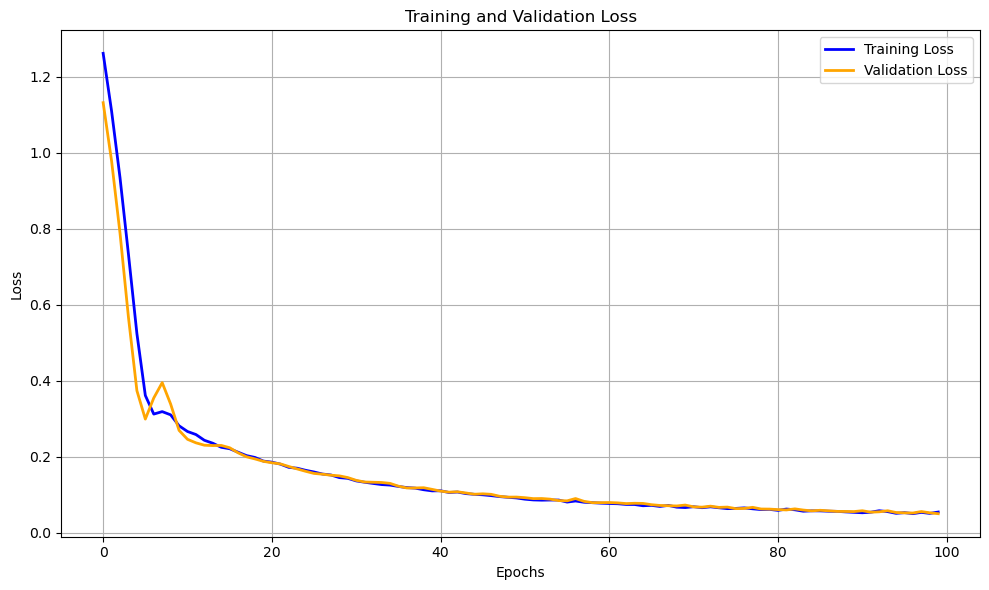

In [47]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [48]:
# Evaluate model on test data
test_loss = model.evaluate(x_test, y_test, verbose=1)

# Print the test loss
print('Test Loss:', test_loss)

# Get predictions from the model
y_pred = model.predict(x_test)

# Convert y_test to a numpy array and reshape
y_test = np.array(y_test).reshape(-1, 1)

# Reshape y_pred to have the same shape as y_test
y_pred = y_pred.reshape(-1, 1)

# Inverse transform to get the original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate RMSE and Rsquared
test_score = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r_squared = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation 
print('Test Score (RMSE): {:.2f}'.format(test_score))
print('R-squared: {:.2f}%'.format(r_squared * 100))

2/2 [==============================] - 0s 12ms/step - loss: 0.0506
Test Loss: 0.050597697496414185
2/2 [==============================] - 2s 6ms/step
Test Score (RMSE): 229.10
R-squared: 97.96%


The method evaluates the LSTM model's performance on a test dataset, giving measures including loss, test loss, RMSE and R-squared. These metrics provide information on the accuracy and usability of the model in the actual world.

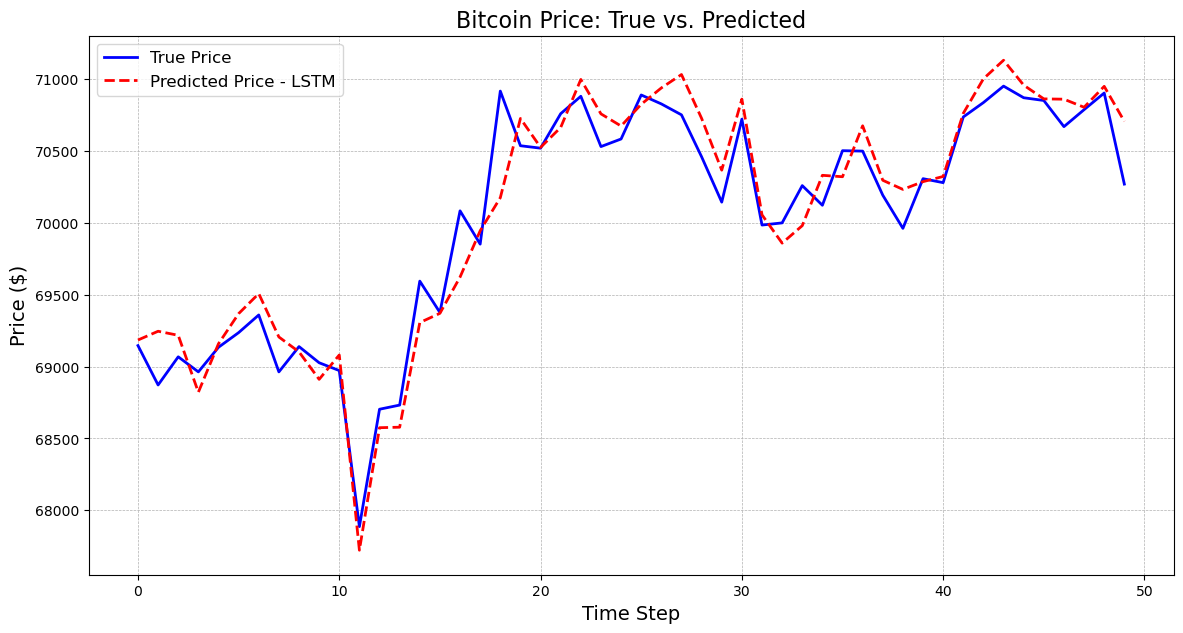

In [23]:

plt.figure(figsize=(14, 7))  

# Plotting the true and predicted prices
plt.plot(y_test_inv, label='True Price', color='blue', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Price - LSTM', color='red', linewidth=2, linestyle='--')

plt.title('Bitcoin Price: True vs. Predicted', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Grid helps in seeing of data points


plt.show()


These code blocks assess the training model against the test data. It predicts the model's loss (mean squared error) on the test information and generates it. It then employs the training model to predict Bitcoin values based on test characteristics ('x_test').

The scaler converts predictions ('y_pred') and true prices ('y_test') back to their original scale.

Following transformation, it computes the root mean squared error (RMSE) and R-squared score between the true and projected prices and publishes these evaluation metrics.

Finally, it graphs the real and forecasted prices versus time steps to show the model's performance.

### Saving the Model

In [25]:
# Save the entire model
#model.save("Final_LSTM%.h5")

# Evaluation


Additional Evaluation Metrics for LSTM Model:
LSTM Mean Absolute Error (MAE): 168.75
LSTM Mean Absolute Percentage Error (MAPE): 0.25%
LSTM Explained Variance Score: 0.98


C:\Users\kanso\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


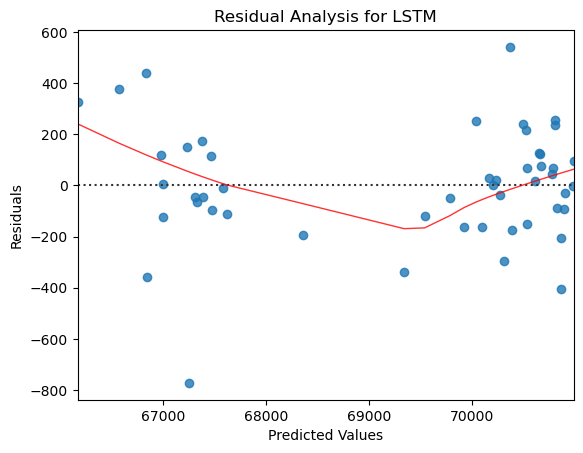

In [49]:
# Calculate additional evaluation metrics for LSTM Model
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
mape_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
explained_variance_lstm = explained_variance_score(y_test_inv, y_pred_inv)

# Print evaluation metrics for LSTM Model
print('\nAdditional Evaluation Metrics for LSTM Model:')
print('LSTM Mean Absolute Error (MAE): {:.2f}'.format(mae_lstm))
print('LSTM Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape_lstm * 100))
print('LSTM Explained Variance Score: {:.2f}'.format(explained_variance_lstm))

# Residual Analysis for LSTM
residuals_lstm = y_test_inv - y_pred_inv
sns.residplot(y_pred_inv.flatten(), residuals_lstm.flatten(), lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis for LSTM')
plt.show()

Here we do residual analysis and compute additional evaluation metrics to assess the performance of the LSTM model. To evaluate how well the model is in predicting outcomes, evaluation measures like Explained Variance Score, Mean Absolute Error (MAPE) and Mean Absolute Error (MAE) are calculated and reported out. To see the distribution and patterns of mistakes produced by the LSTM model, a residual analysis is then carried out by charting residuals compared to expected values.

______

## References

- Harris, Charles, et al. (2020). *Array programming with NumPy*. Nature, 585(7825), 357-362. [https://doi.org/10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)
- Hunter, John D. (2007). *Matplotlib: A 2D Graphics Environment*. Computing in Science & Engineering, 9(3), 90-95. [https://doi.org/10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55)
- McKinney, Wes. (2010). *Data Structures for Statistical Computing in Python*, Proceedings of the 9th Python in Science Conference, 51-56. [https://conference.scipy.org/proceedings/scipy2010/mckinney.html](https://conference.scipy.org/proceedings/scipy2010/mckinney.html)
- Binance API documentation. [https://binance-docs.github.io/apidocs/spot/en/](https://binance-docs.github.io/apidocs/spot/en/)
- Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*, Journal of Machine Learning Research, 12, 2825-2830. [http://jmlr.org/papers/v12/pedregosa11a.html](http://jmlr.org/papers/v12/pedregosa11a.html)
- Chollet, François. (2015). *Keras: Deep Learning for humans*. [https://keras.io](https://keras.io)
- James, Gareth, et al. (2013). *An Introduction to Statistical Learning with Applications in R*. Springer Texts in Statistics. [http://www-bcf.usc.edu/~gareth/ISL/](http://www-bcf.usc.edu/~gareth/ISL/)
- Goodfellow, Ian, et al. (2016). *Deep Learning*. MIT Press. [http://www.deeplearningbook.org](http://www.deeplearningbook.org)
- Hyndman, R.J., & Athanasopoulos, G. (2018). *Forecasting: Principles and Practice*. 2nd ed. Monash University, Australia. [https://otexts.com/fpp2/](https://otexts.com/fpp2/)
- Waskom, Michael. (2021). *Seaborn: Statistical Data Visualization*. Journal of Open Source Software, 6(60), 3021. [https://doi.org/10.21105/joss.03021](https://doi.org/10.21105/joss.03021)

